In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from seaborn import heatmap
import networkx as nx
import copy
import queue
from collections import deque

# Visualising our game's initial settings
Our aim is to move block with index 4 to the escape point [1,2].

In [2]:
#create game, different indexes represent different blocks on the board
#define goal position (escape position)
game = {
    "blocks": [
        {"index": 1, "shape": [1, 2], "position": [3, 1]},
        {"index": 2, "shape": [2, 1], "position": [0, 2]},
        {"index": 3, "shape": [2, 1], "position": [1, 3]},
        {"index": 4, "shape": [1, 2], "position": [1, 0]}
    ],
    "boardSize": [4, 4],
    "escapePoint": [1,2],
}

# Initial board setup
board = [[0 for _ in range(game["boardSize"][0])] for _ in range(game["boardSize"][1])]

# Place blocks on the board
for block in game["blocks"]:
    shape = block["shape"]
    position = block["position"]
    for i in range(shape[0]):
        for j in range(shape[1]):
            board[position[0] + i][position[1] + j] = block["index"]

In [3]:
def print_board(board):
    for row in board:
        print(" ".join(str(cell) if cell != 0 else "#" for cell in row))

def display_heatmap(board):
    df = pd.DataFrame(board)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, cmap="inferno", linewidths=0.1, linecolor="black", annot=True, fmt="d", cbar=False, square=True)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.title("Klotski Maze")
    plt.show()


Initial Position of Blocks:
# # 2 #
4 4 2 3
# # # 3
# 1 1 #

Displaying Heatmap:


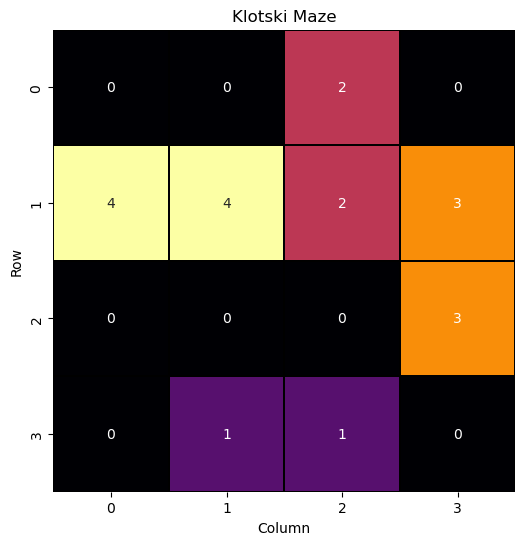

In [4]:
print("\nInitial Position of Blocks:")
print_board(board)

print("\nDisplaying Heatmap:")
display_heatmap(board)

In [5]:
def convert_board(game):
    board = [[0 for _ in range(game["boardSize"][0])] for _ in range(game["boardSize"][1])]

    # Place blocks on the board
    for block in game["blocks"]:
        shape = block["shape"]
        position = block["position"]
        for i in range(shape[0]):
            for j in range(shape[1]):
                board[position[0] + i][position[1] + j] = block["index"]
    return board

initial_board = convert_board(game)
print_board(initial_board)

# # 2 #
4 4 2 3
# # # 3
# 1 1 #


# Define repeatedly used function
`find_block`: find the position of a specific block <br>
`get_shape`: get the shape of a specific block <br>
`is_valid_move`: determine if the move of a block is valid <br>
`move_block`: move a specific block in a specific direction by one step <br>
`revert_board`: return the board to the current state after creating a new board to be append into the queue <br>

In [6]:
def find_block(board, block_index):
    for i in range(4):
        for j in range(4):
            if(board[i][j] == block_index):
                return i,j
            
def get_shape(block_index):
    if block_index == 1 or block_index == 4:
        return 1,2
    else:
        return 2,1

def is_valid_move(board, block_index, direction):
        x, y = find_block(board, block_index)
        shape_x, shape_y = get_shape(block_index)
        
        if direction == "up" and shape_x == 2 and shape_y == 1:
            return x > 0 and board[x-1][y] == 0
        elif direction == "down" and shape_x == 2 and shape_y == 1:
            return x < game["boardSize"][0] - 2 and board[x+2][y] == 0
        elif direction == "left" and shape_x == 1 and shape_y == 2:
            return y > 0 and board[x][y-1] == 0
        elif direction == "right" and shape_x == 1 and shape_y == 2:
            return y < game["boardSize"][1] - 2 and board[x][y+2] == 0
        return False
    
def move_block(board, block_index, direction):
    x, y = find_block(board, block_index)
    if (is_valid_move(board, block_index, direction)==False):
        print("invalid move!")
        return board.copy()
    
    new_board = board
        
    if direction == "up":
        new_board[x-1][y] = block_index
        new_board[x+1][y] = 0
    elif direction == "down":
        new_board[x+2][y] = block_index
        new_board[x][y] = 0
    elif direction == "left":
        new_board[x][y-1] = block_index
        new_board[x][y+1] = 0
    elif direction == "right":
        new_board[x][y+2] = block_index
        new_board[x][y] = 0
    return new_board

def revert_board(board, block_index, direction):
    if direction == "up":
        current_board = move_block(board,block_index,"down")
    elif direction == "down":
        current_board = move_block(board,block_index,"up")
    elif direction == "left":
        current_board = move_block(board,block_index,"right")
    else:
        current_board = move_block(board,block_index,"left")
    return current_board

def print_queue(queue):
    print("The Queue")
    for item in queue:
        board, moves = item
        print("Current Board:")
        print_board(board)
        print("Moves:", moves)
        print()

# Displaying the Puzzle in a Graph

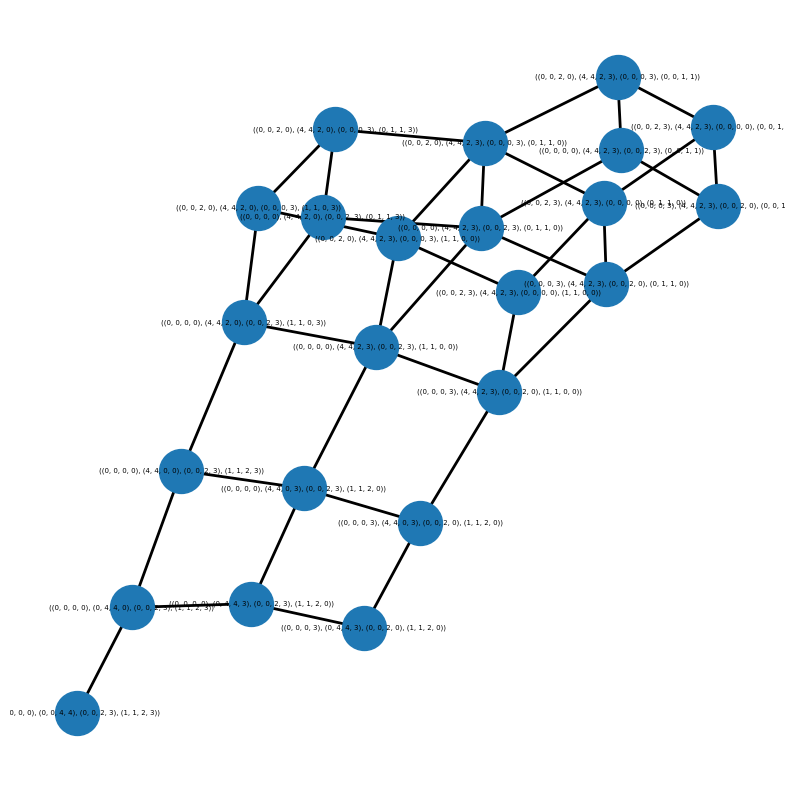

In [16]:
def board_to_graph(game):
    ''' Converts a sliding block puzzle board to corresponding graph
        Input : 2D list representing the board state
        Output : Graph corresponding to the board state
    '''
    start_board = convert_board(game)
    queue = deque([start_board])
    visited = set()
    board_graph = nx.Graph()
    
    while queue: 
        current_board = queue.popleft()
        init_board = copy.deepcopy(current_board)  # Deep copy the current board
        
        if tuple(map(tuple, current_board)) in visited:
            continue
        visited.add(tuple(map(tuple, current_board)))

        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    board_graph.add_node(tuple(map(tuple, copy.deepcopy(new_board))))
                    board_graph.add_edge(tuple(map(tuple, init_board)), tuple(map(tuple, copy.deepcopy(new_board))))
                    queue.append((copy.deepcopy(new_board)))
                    revert_board(new_board, block_index, direction)

    return board_graph

# Convert the board state to a graph
board_graph = board_to_graph(game)

# Helper function to display the graph
def show_graph(graph):
    
    f = plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph)

    nx.draw_networkx_nodes(graph, pos, node_size=1000)
    nx.draw_networkx_edges(graph, pos, width=2)
    nx.draw_networkx_labels(graph, pos, font_size=5)

    plt.axis("off")
    plt.show()

# Display the graph
show_graph(board_graph)


# Method 1: Breadth First Search (BFS)

[(1, 'left'), (2, 'down'), (2, 'down'), (3, 'down'), (4, 'right'), (4, 'right')]
Final Position of Blocks:
# # # #
# # 4 4
# # 2 3
1 1 2 3

Total Number of Moves: 6

Total Nodes Visited:  23

Displaying Heatmap:


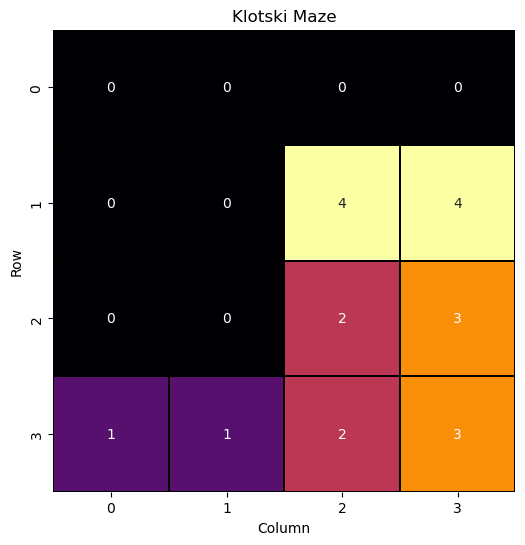

In [8]:
def solve_bfs(game):
    start_board = convert_board(game)
        
    visited = set()
    queue = deque([(start_board, [])])
    num_moves = 0
    final_board = None
    nodes_visited = 0
        
    while queue:
        current_board, moves = queue.popleft()
        current_board = copy.deepcopy(current_board)  # Deep copy the current board
        
        if tuple(map(tuple, current_board)) in visited:
            continue
        visited.add(tuple(map(tuple, current_board)))
        nodes_visited += 1
            
        if current_board[1][2] == 4 and current_board[1][3] == 4:
            final_board = current_board
            num_moves = len(moves)
            break
            
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    queue.append((copy.deepcopy(new_board), moves + [(block_index, direction)]))  # Add the new move to moves
                    revert_board(new_board, block_index, direction) # Revert the move for backtracking (undo the changes made by move_block)
                    
    print(moves)
    return final_board, num_moves, nodes_visited    

final_board, num_moves, nodes_visited = solve_bfs(game)

if final_board is not None:
    print("Final Position of Blocks:")
    print_board(final_board)
    print("\nTotal Number of Moves:", num_moves)
    print("\nTotal Nodes Visited: ", nodes_visited)
    print("\nDisplaying Heatmap:")
    display_heatmap(final_board)
else:
    print("Cannot solve the puzzle with the given move.")


# Method 2: Depth First Search (DFS)

[(3, 'down'), (2, 'down'), (3, 'up'), (3, 'up'), (2, 'up'), (1, 'left'), (3, 'down'), (3, 'down'), (2, 'down'), (3, 'up'), (3, 'up'), (2, 'down'), (4, 'right'), (3, 'down'), (4, 'left'), (3, 'down'), (4, 'right'), (4, 'right')]
Final Position of Blocks:
# # # #
# # 4 4
# # 2 3
1 1 2 3

Total Number of Moves: 18

Total Nodes Visited:  23

Displaying Heatmap:


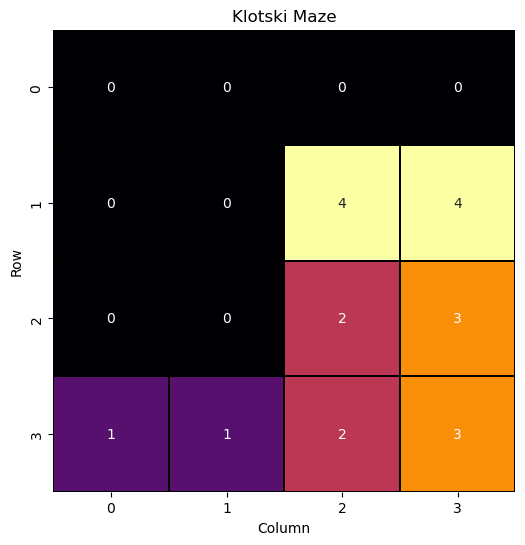

In [9]:
def solve_dfs(game):
    start_board = convert_board(game)
        
    visited = set()
    stack = deque([(start_board, [])])
    num_moves = 0
    final_board = None
    nodes_visited = 0
        
    while queue:
        current_board, moves = stack.pop()
        current_board = copy.deepcopy(current_board)  # Deep copy the current board
        
        if tuple(map(tuple, current_board)) in visited:
            continue
        visited.add(tuple(map(tuple, current_board)))
        nodes_visited += 1
            
        if current_board[1][2] == 4 and current_board[1][3] == 4:
            final_board = current_board
            num_moves = len(moves)
            break
            
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    stack.append((copy.deepcopy(new_board), moves + [(block_index, direction)]))  # Add the new move to moves
                    revert_board(new_board, block_index, direction) # Revert the move for backtracking (undo the changes made by move_block)
                    
    print(moves)
    return final_board, num_moves, nodes_visited    

final_board, num_moves, nodes_visited = solve_dfs(game)

if final_board is not None:
    print("Final Position of Blocks:")
    print_board(final_board)
    print("\nTotal Number of Moves:", num_moves)
    print("\nTotal Nodes Visited: ", nodes_visited)
    print("\nDisplaying Heatmap:")
    display_heatmap(final_board)
else:
    print("Cannot solve the puzzle with the given move.")


# Method 3: Uniform Cost Search (UCS)

[(1, 'left'), (2, 'down'), (2, 'down'), (3, 'down'), (4, 'right'), (4, 'right')]
Final Position of Blocks:
# # # #
# # 4 4
# # 2 3
1 1 2 3

Total Number of Moves: 6

Total Nodes Visited:  23

Displaying Heatmap:


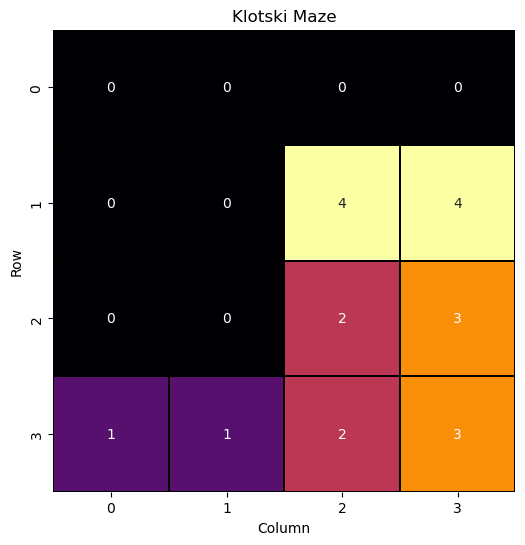

In [10]:
from queue import PriorityQueue

def solve_ucs(game):
    start_board = convert_board(game)
    
    visited = set()
    priority_queue = PriorityQueue()
    priority_queue.put((0, (start_board, [])))  # Priority queue with initial cost 0
    
    num_moves = 0
    final_board = None
    nodes_visited = 0
    
    while not priority_queue.empty():
        cost, (current_board, moves) = priority_queue.get()
        current_board = copy.deepcopy(current_board)  # Deep copy the current board
        
        if tuple(map(tuple, current_board)) in visited:
            continue
        visited.add(tuple(map(tuple, current_board)))
        nodes_visited += 1
        
        if current_board[1][2] == 4 and current_board[1][3] == 4:
            final_board = current_board
            num_moves = len(moves)
            break
        
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    priority_queue.put((cost + 1, (copy.deepcopy(new_board), moves + [(block_index, direction)])))  # Add the new move to moves
                    revert_board(new_board, block_index, direction) # Revert the move for backtracking (undo the changes made by move_block)
        
    print(moves)
    return final_board, num_moves, nodes_visited

final_board, num_moves, nodes_visited = solve_ucs(game)

if final_board is not None:
    print("Final Position of Blocks:")
    print_board(final_board)
    print("\nTotal Number of Moves:", num_moves)
    print("\nTotal Nodes Visited: ", nodes_visited)
    print("\nDisplaying Heatmap:")
    display_heatmap(final_board)
else:
    print("Cannot solve the puzzle with the given move.")


# Method 4: Greedy-Search (GS)

Final Position of Blocks:
# # # #
# # 4 4
# # 2 3
1 1 2 3

Total Number of Moves: 6

Total Nodes Visited:  7

Displaying Heatmap:


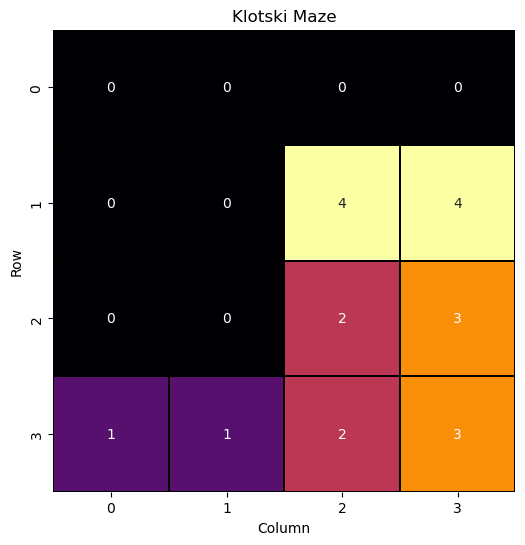

In [11]:
def heuristic(board):
    i,j = find_block(board,4)
    return abs(3-(j+1))

def solve_gs(game):
    start_board = convert_board(game)
    
    visited = set()
    priority_queue = PriorityQueue()
    priority_queue.put((0, start_board))  # Priority queue with initial cost 0
    
    num_moves = 0
    final_board = None
    nodes_visited = 0
    
    while not priority_queue.empty():
        _, current_board = priority_queue.get()
        
        if tuple(map(tuple, current_board)) in visited:
            continue
        visited.add(tuple(map(tuple, current_board)))
        nodes_visited += 1
        
        if current_board[1][2] == 4 and current_board[1][3] == 4:
            final_board = current_board
            break
        
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    priority = heuristic(new_board)  # Greedy search uses only heuristic as priority
                    priority_queue.put((priority, copy.deepcopy(new_board)))
                    revert_board(new_board, block_index, direction)
        
    num_moves = len(visited) - 1  # Number of visited nodes minus the start node
    
    return final_board, num_moves, nodes_visited

final_board, num_moves, nodes_visited = solve_gs(game)

if final_board is not None:
    print("Final Position of Blocks:")
    print_board(final_board)
    print("\nTotal Number of Moves:", num_moves)
    print("\nTotal Nodes Visited: ", nodes_visited)
    print("\nDisplaying Heatmap:")
    display_heatmap(final_board)
else:
    print("Cannot solve the puzzle with the given move.")


# Method 5: A *Search

[(1, 'left'), (2, 'down'), (2, 'down'), (4, 'right'), (3, 'down'), (4, 'right')]
Final Position of Blocks:
# # # #
# # 4 4
# # 2 3
1 1 2 3

Total Number of Moves: 6

Total Nodes Visited:  20

Displaying Heatmap:


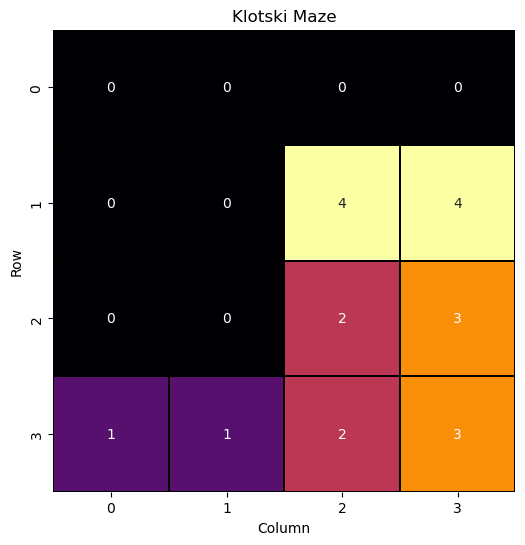

In [12]:
def solve_a_star(game):
    start_board = convert_board(game)
    
    visited = set()
    priority_queue = PriorityQueue()
    priority_queue.put((0, (start_board, [])))  # Priority queue with initial cost 0
    
    num_moves = 0
    final_board = None
    nodes_visited = 0
    
    while not priority_queue.empty():
        _, (current_board, moves) = priority_queue.get()
        current_board = copy.deepcopy(current_board)  # Deep copy the current board
        
        if tuple(map(tuple, current_board)) in visited:
            continue
        visited.add(tuple(map(tuple, current_board)))
        nodes_visited += 1
        
        if current_board[1][2] == 4 and current_board[1][3] == 4:
            final_board = current_board
            num_moves = len(moves)
            break
        
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    cost = len(moves) + 1 + heuristic(new_board)  # Actual cost + heuristic estimate
                    priority_queue.put((cost, (copy.deepcopy(new_board), moves + [(block_index, direction)])))  # Add the new move to moves
                    revert_board(new_board, block_index, direction)
        
    print(moves)
    return final_board, num_moves, nodes_visited

final_board, num_moves, nodes_visited = solve_a_star(game)

if final_board is not None:
    print("Final Position of Blocks:")
    print_board(final_board)
    print("\nTotal Number of Moves:", num_moves)
    print("\nTotal Nodes Visited: ", nodes_visited)
    print("\nDisplaying Heatmap:")
    display_heatmap(final_board)
else:
    print("Cannot solve the puzzle with the given move.")


# Method 6: Biderectional Search (BS)

[(1, 'left'), (2, 'down')]
[(4, 'left'), (3, 'up'), (4, 'left')]
Final Position of Blocks:
# # # #
# # 4 4
# # 2 3
1 1 2 3

Total Number of Moves: 6

Total Nodes Visited:  13

Displaying Heatmap:


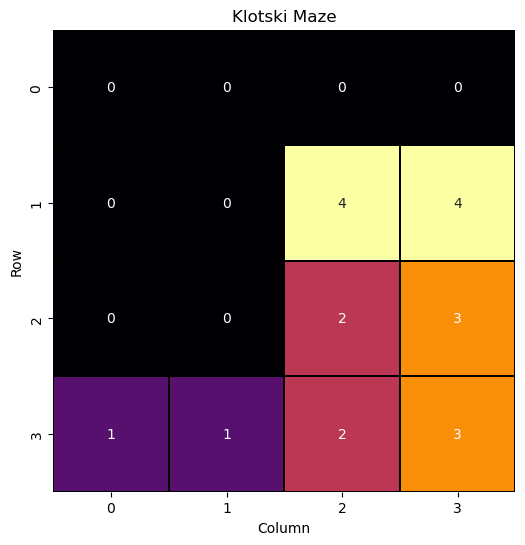

In [13]:
def solve_bs(game):
    start_board = convert_board(game)
    goal_board = [[0, 0, 0, 0], [0, 0, 4, 4], [0, 0, 2, 3], [1, 1, 2, 3]]  
    
    start_visited = set()
    start_queue = deque([(start_board, [])])
    start_visited.add(tuple(map(tuple, start_board)))
    
    goal_visited = set()
    goal_queue = deque([(goal_board, [])])
    goal_visited.add(tuple(map(tuple, goal_board)))
    
    num_moves = 0
    final_board = None
    nodes_visited = 0
    
    while start_queue and goal_queue:
        # Forward search from start state
        current_board, moves1 = start_queue.popleft()
        nodes_visited += 1
        
        if tuple(map(tuple, current_board)) in goal_visited:
            final_board = current_board
            num_moves = len(moves1)+len(moves2)+1
            break
        
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    if tuple(map(tuple, new_board)) not in start_visited:
                        start_queue.append((copy.deepcopy(new_board), moves1 + [(block_index, direction)]))
                        start_visited.add(tuple(map(tuple, new_board)))
                    revert_board(new_board, block_index, direction)
        
        # Backward search from goal state
        current_board, moves2 = goal_queue.popleft()
        nodes_visited += 1
        
        if tuple(map(tuple, current_board)) in start_visited:
            final_board = current_board
            num_moves = len(moves1)+len(moves2)
            break
        
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    if tuple(map(tuple, new_board)) not in goal_visited:
                        goal_queue.append((copy.deepcopy(new_board), moves2 + [(block_index, direction)]))
                        goal_visited.add(tuple(map(tuple, new_board)))
                    revert_board(new_board, block_index, direction)
    
    print(moves1)
    print(moves2)
    return goal_board, num_moves, nodes_visited

final_board, num_moves, nodes_visited = solve_bs(game)

if final_board is not None:
    print("Final Position of Blocks:")
    print_board(final_board)
    print("\nTotal Number of Moves:", num_moves)
    print("\nTotal Nodes Visited: ", nodes_visited)
    print("\nDisplaying Heatmap:")
    display_heatmap(final_board)
else:
    print("Cannot solve the puzzle with the given move.")


# Method 7: Iterative Deepening A* (IDA*)

Final Position of Blocks:
# # # #
# # 4 4
# # 2 3
1 1 2 3

Total Number of Moves: 3

Total Nodes Visited:  57

Displaying Heatmap:


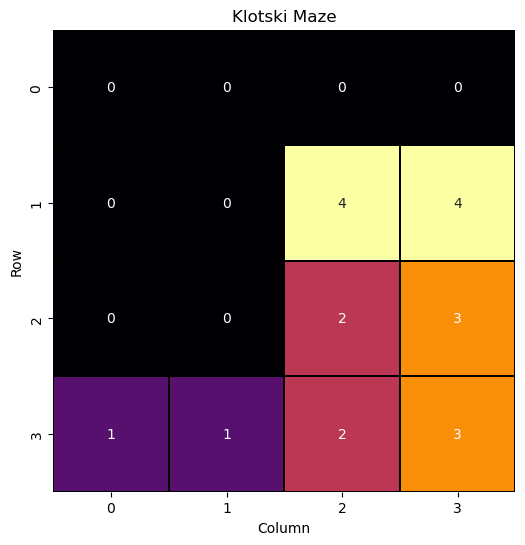

In [14]:
def solve_ida(game):
    start_board = convert_board(game)
    threshold = heuristic(start_board)
    
    num_moves = 0
    final_board = None
    nodes_visited = 0
    
    while True:
        result, new_threshold, visited = ida_star_dfs(start_board, threshold)
        nodes_visited += visited
        
        if result is not None:
            final_board = result
            num_moves = len(result) - 1  # Number of moves is the depth of the solution path
            break
        
        if new_threshold == float('inf'):
            break
        
        threshold = new_threshold
    
    return final_board, num_moves, nodes_visited

def ida_star_dfs(board, threshold):
    stack = [(board, [], 0)]
    visited = set()
    visited.add(tuple(map(tuple, board)))
    
    nodes_visited = 0
    
    while stack:
        current_board, moves, cost = stack.pop()
        nodes_visited += 1
        
        if current_board[1][2] == 4 and current_board[1][3] == 4:
            return current_board, float('inf'), nodes_visited  # Solution found
        
        f = cost + heuristic(current_board)
        
        if f > threshold:
            return None, f, nodes_visited  # Exceeds threshold
        
        for i in range(4):
            block_index = i + 1
            for direction in ["up", "down", "left", "right"]:
                if is_valid_move(current_board, block_index, direction):
                    new_board = move_block(current_board, block_index, direction)
                    if tuple(map(tuple, new_board)) not in visited:
                        stack.append((copy.deepcopy(new_board), moves + [(block_index, direction)], cost + 1))
                        visited.add(tuple(map(tuple, new_board)))
                    revert_board(new_board, block_index, direction)
    
    return None, threshold, nodes_visited  # Solution not found within threshold

final_board, num_moves, nodes_visited = solve_ida(game)

if final_board is not None:
    print("Final Position of Blocks:")
    print_board(final_board)
    print("\nTotal Number of Moves:", num_moves)
    print("\nTotal Nodes Visited: ", nodes_visited)
    print("\nDisplaying Heatmap:")
    display_heatmap(final_board)
else:
    print("Cannot solve the puzzle with the given move.")


# Comparing effectiveness of different algorithms 

|Algorithms |Total Number of Moves| Total Nodes Visited|
|---|---|---|
|Breadth First Search (BFS)| 6 | 23 |
|Depth First Search (DFS) | 18 | 23 |
|Uniform Cost Search (UCS) | 6 | 23 |
|Greedy Search (GS) | 6 | 7 |
|A* Search | 6 | 20 |
|Bidirectional Search (BS) | 6 | 13 |
|Iterative Deepening A* (IDA*) | 6 | 57 |

With that, we conclude that the most effective algorithm to solve this moving block puzzle is **Greedy Search**.